<center><a href="https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/main/03-Deep-Learning/notebooks/12-GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a></center>

<h2>What are GANs?</h2>

[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs, 2014) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to tell real images apart from fakes.

![A diagram of a generator and discriminator](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan1.png?raw=1)

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

![A second diagram of a generator and discriminator](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan2.png?raw=1)

This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

To learn more about GANs, see MIT's [Intro to Deep Learning](http://introtodeeplearning.com/) course.

# Deep Convolutional GAN

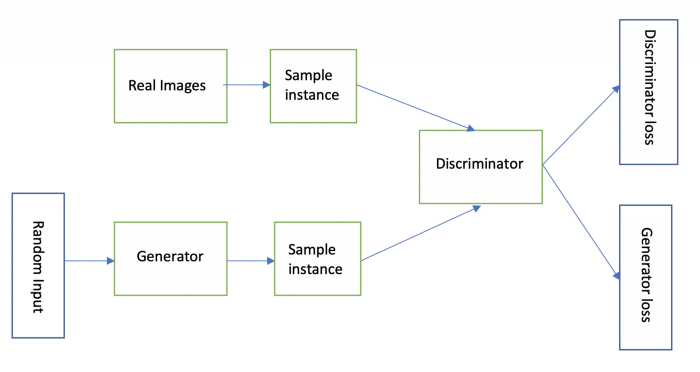

En este ejemplo entrenaremos una GAN en el corpus MNIST

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.datasets.mnist import load_data
from numpy import expand_dims

(X_train, _), _ = load_data()
print(X_train.shape)

# ----- Añadimos una dimensión para el canal de la imágen
X = expand_dims(X_train, axis=-1)
print(X.shape)

# ----- Preparamos los datos y re-escalamos
X = X.astype('float32')
X = X / 255.0

**Sugerencia:** Correr el resto de la notebook ahora

## Generador

Definimos el generador.

* Observa la capa `Conv2DTranspose`, esta capa realiza lo opuesto a una capa de convolución, suele llamarse *deconvolución*. De acuerdo a la [documentación](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/):

    *The need for transposed convolutions generally arises from the desire to use a transformation going in the opposite direction of a normal convolution, i.e., from something that has the shape of the output of some convolution to something that has the shape of its input while maintaining a connectivity pattern that is compatible with said convolution.*
* En esta capa, el tamaño de la imagen queda determinado por una relación entre los hiperparámetros. [Guía](https://arxiv.org/abs/1603.07285v1) con más información.

* Por otro lado, observa la capa de salida, ¿qué forma tiene? ¿qué activación tiene?
* Finalmente, observa que este modelo no se compila.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout

latent_dim = 100 # Dimensión a partir de la cual generaremos las imágenes

g_model = Sequential(name="generador")
# comenzaremos con una imagen de 7x7
n_nodes = 128 * 7 * 7
g_model.add(Dense(n_nodes, input_dim=latent_dim))
g_model.add(LeakyReLU(alpha=0.2))
g_model.add(Reshape((7, 7, 128)))
# sobremuestreamos al tamaño 14x14
g_model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
g_model.add(LeakyReLU(alpha=0.2))
# sobremuestreamos al tamaño 28x28
g_model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
g_model.add(LeakyReLU(alpha=0.2))
g_model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))

g_model.summary()

Ya podemos generar imágenes, aún sin haber entrenado el modelo.

Podemos generar predicciones de dos maneras:

* Llamando al modelo
* Con el método `predict`

[Más información](https://keras.io/getting_started/faq/#whats-the-difference-between-model-methods-predict-and-call)

<img align="left" width="50%" src="https://github.com/DCDPUAEM/DCDP/blob/main/03-Deep-Learning/img/keras-call-vs-predict.png?raw=1"/>

In [ ]:
import matplotlib.pyplot as plt

noise = tf.random.normal([1, latent_dim]) # vector con ruido gaussiano

# ----- Pasamos el ruido a través de la red con el método 'predict':
generated_image = g_model.predict(noise)

# ----- Pasamos el ruido a través de la red con el método 'call':
# generated_image = g_model(noise)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show()

## Discriminador

Definimos la red discriminadora, esta es una red CNN para clasificación binaria. **Esto ya lo sabemos hacer**

In [ ]:
from tensorflow.keras.optimizers import Adam

d_model = Sequential(name='discriminador')
d_model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(28,28,1)))
d_model.add(LeakyReLU(alpha=0.2))
d_model.add(Dropout(0.4))
d_model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
d_model.add(LeakyReLU(alpha=0.2))
d_model.add(Dropout(0.4))
d_model.add(Flatten())
d_model.add(Dense(1, activation='sigmoid'))  # <---- Clasificación binaria

opt = Adam(learning_rate=0.0002, beta_1=0.5)
d_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) # <---- Clasificación binaria

d_model.summary()

Utilizamos el discriminador (aún no entrenado) para clasificar las imágenes generadas como reales o falsas. El modelo será entrenado para dar valores positivos a las imágenes reales y negativos a las falsas.

Probemos con la imagen generada a partir del modelo `g_model` (que aún no ha sido entrenado).

In [ ]:
decision = d_model.predict(generated_image)
print(decision)

## Definimos el modelo GAN completo

In [ ]:
# Hacer que los pesos en el modelo discriminador no sean entrenables
d_model.trainable = False

# Conectamos los modelos, primero irá el generador, luego el discriminador.
gan_model = Sequential(name="GAN")
# --- generador ---
gan_model.add(g_model)
# --- discriminador ---
gan_model.add(d_model)

optimizador = Adam(learning_rate=0.0002, beta_1=0.5)
gan_model.compile(loss='binary_crossentropy', optimizer=optimizador) # Es una tarea de clasificación binaria

gan_model.summary(show_trainable=True)

## Entrenamiento

Dada la arquitectura del modelo, no podemos usar el método `fit` directamente para entrenar el modelo GAN. Definimos nuestro propio entrenamiento

In [ ]:
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
import matplotlib.pyplot as plt

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=256):
	batches_per_epoch = int(dataset.shape[0]/n_batch) # Calculamos cuántos lotes se necesitan por época
	half_batch = int(n_batch/2)
	for i in range(n_epochs):
		for j in range(batches_per_epoch):
			X_real, y_real = generate_real_samples(dataset, half_batch)				# Imágenes reales
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch) # Imágenes falsas
			X, y = vstack((X_real,X_fake)), vstack((y_real,y_fake)) # Las juntamos
			d_loss, _ = d_model.train_on_batch(X, y) # Entrenamos el discriminador con estás imágenes, recordar que este no se entrena con el 'GAN'
			X_gan = generate_latent_points(latent_dim, n_batch) # Generamos vectores latentes
			y_gan = ones((n_batch,1))
			g_loss = gan_model.train_on_batch(X_gan, y_gan) # Entranamos el modelo GAN completo (sólo se entrena el generador)
			print('epoch: %d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, batches_per_epoch, d_loss, g_loss))  # Imprimimos la información
		if (i+1)%2 == 0: # Cada dos épocas generamos imágenes falsas, las guardamos y graficamos
			X_fake, y_fake = generate_fake_samples(g_model,latent_dim,100)
			plot_n_save(X_fake,i+1)
	acc_real, acc_fake = summarize_performance(g_model, d_model, dataset, latent_dim)  # Evaluamos el desempeño al final del entrenamiento
	return acc_real, acc_fake

# Regresar vectores en el espacio latente para que entren al generador
def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# Regresamos n_samples imágenes falsas, usando el generador, junto con sus etiquetas
def generate_fake_samples(g_model, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = g_model.predict(x_input)
	y = zeros((n_samples, 1)) # Todas serán falsas, es decir, clase negativa
	return X, y

# Regresamos una colección aleatoria de n_samples imágenes reales, junto con sus etiquetas
def generate_real_samples(dataset, n_samples):
	idxs = randint(0, dataset.shape[0], n_samples)
	X = dataset[idxs]
	y = ones((n_samples, 1))  # Todas serán reales, es decir, clase positiva
	return X, y

# Crear y guardar un grid de imágenes falsas
def plot_n_save(examples, epoch, n=10):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	filename = 'generated_plot_e%03d.png' % (epoch)
	plt.savefig(filename,dpi=120)
	plt.close()

# Evaluar el discriminador en las imágenes falsas y verdaderas
def summarize_performance(g_model, d_model, dataset, latent_dim, n_samples=100):
	X_real, y_real = generate_real_samples(dataset, n_samples)
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	print('>Accuracy - real: %.0f%%, fake: %.0f%% -' % (acc_real*100, acc_fake*100))
	return acc_real, acc_fake

Entrenamos el modelo. Tarda alrededor de 10 minutos

In [ ]:
acc_real, acc_fake = train(g_model, d_model, gan_model, X, latent_dim, n_epochs=15)

Veamos el rendimiento del modelo GAN (en la tarea de discriminar) en ambas clases.

In [ ]:
acc_real, acc_fake

Al ser modelos grandes, es buena idea guardarlos. También podríamos haber guardado con el callback *Checkpoint*.

In [ ]:
gan_model.save('gan-model.model')
d_model.save('discriminator-model.model')
g_model.save('generative-model.model')

Finalmente, visualicemos el progreso del entrenamiento.

In [ ]:
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
import glob
import imageio

anim_file = 'gan-evolution.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('generated_plot*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


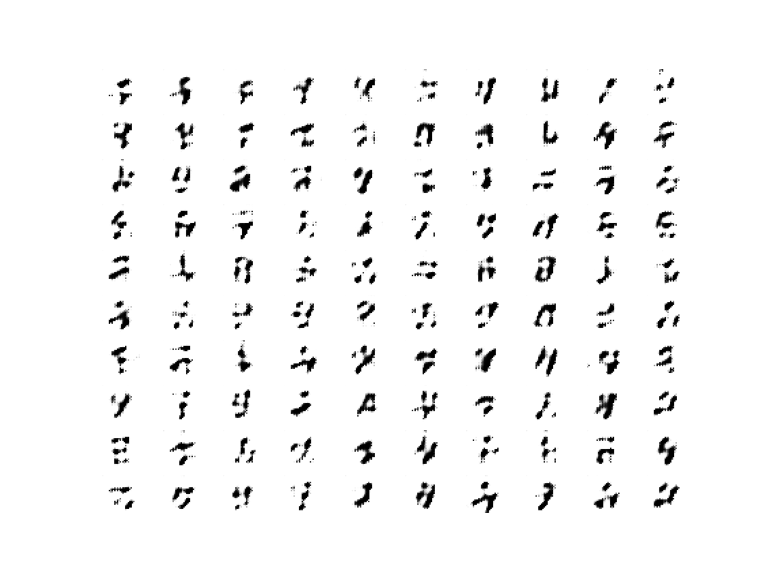

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)